# Testing Script U-Net Semengtic Segmentaion

In [2]:
import tensorflow as tf
import numpy as np
import os 
import shutil
import numpy as np 
import pandas as pd 
import imageio 
import matplotlib.pyplot as plt 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import load_model
%matplotlib inline

# Path to test DataSet

In [3]:
path = '/Users/shoeb.ahmad/Desktop/AI Hub/Jupyter Notebooks/Unet++/Satalite Aerial Images/Data/Test_Data/'
Name_of_Test_Image_folder = 'image_test'
Name_of_Test_Mask_folder = 'mask_test'
Test_image_path = os.path.join(path,Name_of_Test_Image_folder +'//')
Validation_mask_path = os.path.join(path,Name_of_Test_Mask_folder +'//')
image_list = os.listdir(Test_image_path)
mask_list = os.listdir(Validation_mask_path)
image_list = [Test_image_path+i for i in image_list if i != '.DS_Store']
mask_list = [Validation_mask_path+i for i in mask_list if i != '.DS_Store']
image_list = sorted(image_list)
mask_list = sorted(mask_list)
print("Total number of images is : {} ".format(len(image_list)))

Total number of images is : 24 


# Preprocessing function

In [4]:
def process_path(image_path,mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.convert_image_dtype(img,tf.float32) #this do the same as dividing by 255 to set the values between 0 and 1 (normalization)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask,channels=3)
    mask = tf.math.reduce_max(mask,axis=-1,keepdims=True)
    return img , mask

def preprocess(image,mask) : 
    input_image = tf.image.resize(image,(96,128),method='nearest')
    input_mask = tf.image.resize(mask,(96,128),method='nearest')
    
    return input_image , input_mask
image_list_dataset = tf.data.Dataset.list_files(image_list ,shuffle=False)
mask_list_dataset = tf.data.Dataset.list_files(mask_list , shuffle=False)
images_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((images_filenames
                                              ,masks_filenames))
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
test_dataset = processed_image_ds.cache().shuffle(5).batch(4)

Metal device set to: Apple M1 Pro


2022-06-07 14:41:09.743270: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-07 14:41:09.743670: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# load Model

In [5]:
Model = load_model(path + 'Drone_Areal_Images_updated.h5')

# Display Function

In [6]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = Model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

# Model Evaluation function

In [7]:

def evaluate_model(true_masks, predicted_masks, n_classes, smooth = 1e-6):
    

    # Create empty lists to store evaluation metric outputs
    class_wise_true_positives, class_wise_true_negatives = [],[]
    class_wise_false_positives, class_wise_false_negatives = [],[]
    class_wise_precisions, class_wise_recalls = [],[] 
    class_wise_specificities, class_wise_ious = [],[] 
    class_wise_tdrs, class_wise_f1_scores = [],[]
    classes = []
            
    for clas in range(n_classes):
        true_positives, true_negatives, false_positives, false_negatives = 0,0,0,0
        precisions, recalls, specificities, ious, f1_scores, tdrs = 0,0,0,0,0,0        
        
        number_of_masks = true_masks.shape[0]
        
        for mask_id in range(number_of_masks):
            true_positive = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]==clas))
            true_negative = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]!=clas))
            false_positive = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]==clas))
            false_negative = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]!=clas))
            
            true_positives += true_positive
            true_negatives += true_negative
            false_positives += false_positive
            false_negatives += false_negative

        recall = round(true_positives/(true_positives + false_negatives + smooth), 2)
        precision = round(true_positives/(true_positives + false_positives + smooth), 2)
        specificity = round(true_negatives/(true_negatives + false_positives + smooth), 2)
        tdr = round((1 - (false_negatives/(true_positives + false_negatives + smooth))), 2)
        iou = round(true_positives/(true_positives + false_negatives + false_positives + smooth), 2)
        f1_score = round((2 * precision * recall)/(precision + recall + smooth), 2)
        
        class_wise_true_positives.append(true_positives)
        class_wise_true_negatives.append(true_negatives)
        class_wise_false_positives.append(false_positives)
        class_wise_false_negatives.append(false_negatives)
        class_wise_recalls.append(recall)
        class_wise_precisions.append(precision)
        class_wise_specificities.append(specificity)
        class_wise_ious.append(iou)
        class_wise_tdrs.append(tdr)
        class_wise_f1_scores.append(f1_score)
        classes.append("Class " + str(clas+1))
        # class_wise_pixel_accuracies.append(pixel_accuracy)
        
    total_true_positives = np.sum(class_wise_true_positives)
    total_true_negatives = np.sum(class_wise_true_negatives)
    total_false_positives = np.sum(class_wise_false_positives)
    total_false_negatives = np.sum(class_wise_false_negatives)
    mean_recall = round(np.average(np.array(class_wise_recalls)), 2)
    mean_precision = round(np.average(np.array(class_wise_precisions)), 2)
    mean_specificity = round(np.average(np.array(class_wise_specificities)), 2)
    mean_iou = round(np.average(np.array(class_wise_ious)), 2)
    mean_tdr = round(np.average(np.array(class_wise_tdrs)), 2)
    mean_f1_score = round(np.average(np.array(class_wise_f1_scores)), 2)    
         
    class_wise_evaluations = {"Class": classes,
                              "True Positive Pixels": class_wise_true_positives,
                              "True Negative Pixels": class_wise_true_negatives,
                              "False Positive Pixels": class_wise_false_positives,
                              "False Negative Pixels": class_wise_false_negatives,
                              "Recall": class_wise_recalls,
                              "Precision": class_wise_precisions,
                              "Specificity": class_wise_specificities,
                              "IoU": class_wise_ious,
                              "TDR": class_wise_tdrs,
                              "F1-Score": class_wise_f1_scores}

    overall_evaluations = {"Class": "All Classes",
                        "True Positive Pixels": total_true_positives,
                        "True Negative Pixels": total_true_negatives,
                        "False Positive Pixels": total_false_positives,
                        "False Negative Pixels": total_false_negatives,
                        "Recall": mean_recall,
                        "Precision": mean_precision,
                        "Specificity": mean_specificity,
                        "IoU": mean_iou,
                        "TDR": mean_tdr,
                        "F1-Score": mean_f1_score}
    
    evaluations = {"Overall Evaluations": overall_evaluations, 
                   "Class-wise Evaluations": class_wise_evaluations}
    
    return evaluations
def show_evaluations(evaluations, 
                     metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1 Score"], 
                     class_list=None,
                     display_evaluations="All"):
    """
    Returns a pandas dataframe containing specified metrics
        
        Arguments:
            evaluations: evaluation output from the evaluate_model function
            metrics: a list containing one or more of the following metrics:
                     'True Positive', 'True Negative', 'False Positive', 'False Negative',
                     'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'
            display_evaluations: one of 'All' to display both overall and class-wise evaluations,
                                 'Overall' to display only the overall evaluations,
                                 'Class-wise' to display only the classwise evaluations.
            class_list: list or tuple containing names of segmentation class.
    """
    
    # Split evaluations into overall and class-wise evaluations
    overall_evaluations = evaluations["Overall Evaluations"]
    class_wise_evaluations = evaluations["Class-wise Evaluations"]
    
    # Validate list of metrics 
    for metric_id in range(len(metrics)):
        metric = metrics[metric_id]
        if metric not in overall_evaluations:
            raise ValueError("'metrics argument' not properly defined. "
                            "Kindly create a list containing one or more of the following metrics: "
                             "'True Positive', 'True Negative', 'False Positive', 'False Negative', "
                             "'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'") 
    
    # Check if class_list is none
    if class_list != None and all(isinstance(class_, str) for class_ in class_list):
        if len(class_list) == len(class_wise_evaluations["Class"]):
            class_list = [class_list]
        else:
            raise ValueError("class_list argument' not properly defined. " 
                             "List is either shorter or longer than segmentation classes") 
    else:
        class_list = [class_wise_evaluations["Class"]]                             
    
    # Extract data from the evaluations
    overall_data = [overall_evaluations["Class"]] + [overall_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    classwise_data = class_list + [class_wise_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    overall_data = np.array(overall_data).reshape(1,-1)
    classwise_data = np.array(classwise_data).transpose()
    
    # Determine the type of evaluation report to display
    if display_evaluations.lower() == "all":
        data = np.concatenate((overall_data, classwise_data), axis=0)
    elif display_evaluations.lower() == "overall":
        data = overall_data
    elif display_evaluations.lower() == "class-wise" or "classwise":
        data = classwise_data
    else:
        raise ValueError("Display argument are not properly defined."
                        "Kindly use 'All' to display both overall and class-wise evaluations."
                        "Use 'Overall' to display only the overall evaluations."
                        "Or use 'Class-wise' to display only the class-wise evaluations")

    
    # Create evaluation report as a pandas dataframe
    dataframe = pd.DataFrame(data)
    dataframe_titles = ["Class"] + metrics
    dataframe.columns = dataframe_titles
    # dataframe = dataframe.set_index(dataframe_titles[0], col_level=1)
    
    return dataframe

# Prediction and Evaluation

2022-06-07 14:41:27.410142: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 268ms/step


2022-06-07 14:41:29.488057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


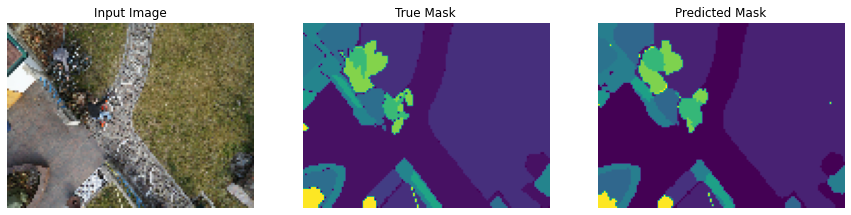

1/1 [==============================] - 0s 14ms/step


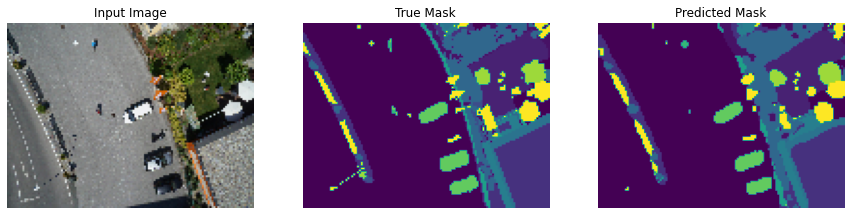

1/1 [==============================] - 0s 13ms/step


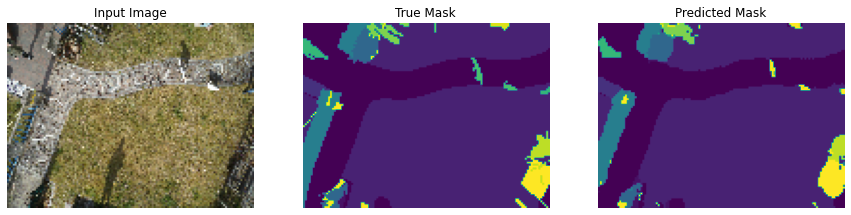

1/1 [==============================] - 0s 11ms/step


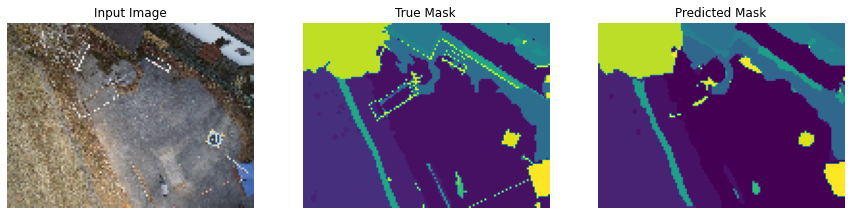

1/1 [==============================] - 0s 12ms/step


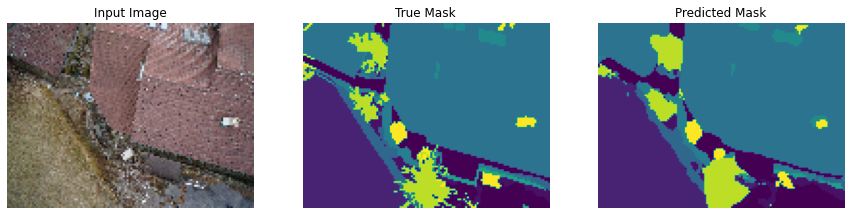

In [8]:
show_predictions(test_dataset, 5)

1/1 [==============================] - 0s 16ms/step


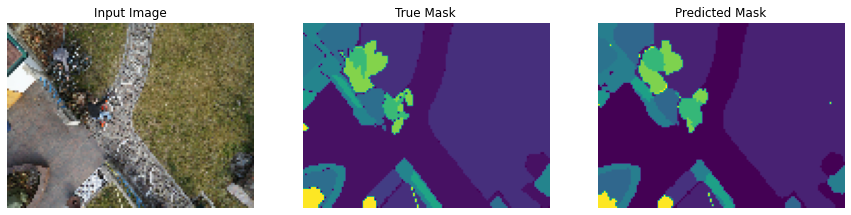

1/1 [==============================] - 0s 11ms/step


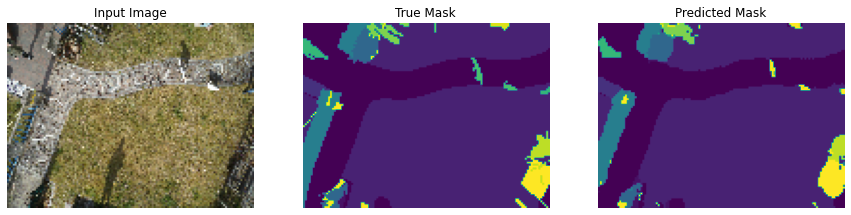

1/1 [==============================] - 0s 12ms/step


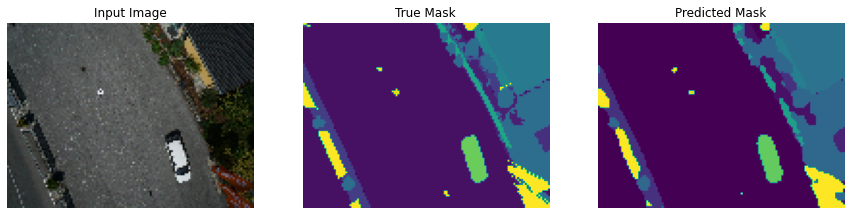

1/1 [==============================] - 0s 10ms/step


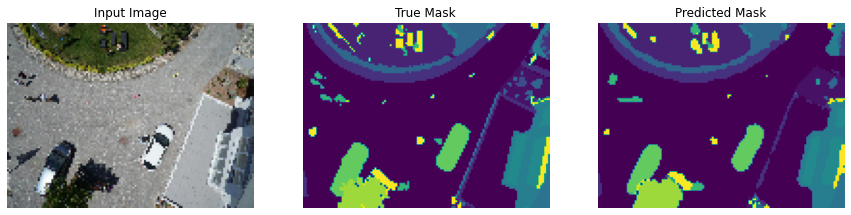

1/1 [==============================] - 0s 11ms/step


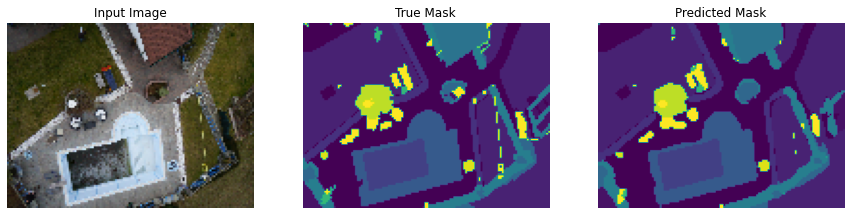

In [9]:
show_predictions(test_dataset, 5)

In [11]:
test_loss, test_accuracy = Model.evaluate(test_dataset, batch_size = 16)

6/6 [==============================] - 0s 15ms/step - loss: 0.2154 - accuracy: 0.9304


In [12]:
print(f'Model Accuracy on the Test Dataset: {round(test_accuracy * 100, 2)}%')

Model Accuracy on the Test Dataset: 93.04%


In [13]:
def create_mask(dataset, model):
    true_masks, predicted_masks = [], []
    for images, masks in dataset:
        pred_masks = Model.predict(images)
        pred_masks = tf.expand_dims(tf.argmax(pred_masks, axis=-1), axis=-1)
        true_masks.extend(masks)
        predicted_masks.extend(pred_masks)
        
    true_masks = np.array(true_masks)
    predicted_masks = np.array(predicted_masks)
        
    return true_masks, predicted_masks
true_test_masks, predicted_test_masks = create_mask(test_dataset, Model)

1/1 [==============================] - 0s 11ms/step


In [14]:
model_evaluation_on_test_dataset = evaluate_model(true_test_masks, predicted_test_masks, n_classes=23)

show_evaluations(model_evaluation_on_test_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=None, 
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.74,0.85,1.0,0.68,0.74,0.76
1,Class 1,0.0,0.0,1.0,0.0,0.0,0.0
2,Class 2,0.98,0.96,0.97,0.94,0.98,0.97
3,Class 3,0.86,0.84,0.99,0.74,0.86,0.85
4,Class 4,0.98,0.97,0.99,0.95,0.98,0.97
5,Class 5,0.85,0.92,1.0,0.79,0.85,0.88
6,Class 6,0.98,0.97,1.0,0.95,0.98,0.97
7,Class 7,0.71,0.83,1.0,0.62,0.71,0.77
8,Class 8,0.97,0.98,1.0,0.95,0.97,0.97
9,Class 9,0.88,0.85,0.99,0.76,0.88,0.86
